In [1]:
%config IPCompleter.greedy=True
#Press Shift + Tab to trigger autocomplete.

In [2]:
#**Import Libraries :**
#@title Import and Install Libraries { vertical-output: true, display-mode: "form" }

from IPython import display

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf
import os
import keras
import time
import shutil
import csv
import imageio
import scipy.io
import pandas as pd
import sys
import glob
import seaborn as sbn
import gc

from sklearn import metrics
from keras.layers import Input
from tensorflow.keras.layers import GlobalAvgPool2D, Dropout, Dense
from keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras_layer_normalization import LayerNormalization
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image

from scipy.optimize import brentq
from scipy.interpolate import interp1d

from skimage import io, color
from skimage.color import gray2rgb
from sklearn.metrics import confusion_matrix

print("All libraries are imported successfully")

2024-07-07 22:27:44.627004: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


All libraries are imported successfully


In [3]:
# @title Defining  Paths and Parameters
class Path :
  def __init__(self, choice, num) :
    name = choice # choice = "132+800" | choice = "50+150" | choice = "206+200"

    self.train = "/truba_scratch/tbag151/KMO_Sample_Dataset/Train/" + name
    self.test = "/truba_scratch/tbag151/KMO_Sample_Dataset/Test/" + name
    self.training_dataset = "/truba_scratch/tbag151/KMO_Sample_Dataset/Training_dataset/" + name
    self.validation_dataset = "/truba_scratch/tbag151/KMO_Sample_Dataset/Validation_dataset/" + name
    self.test_dataset = "/truba_scratch/tbag151/KMO_Sample_Dataset/Test_dataset/" + name
    self.training_dataset_normal = "/truba_scratch/tbag151/KMO_Sample_Dataset/Training_dataset/" + name + "/Normal"
    self.training_dataset_anomaly = "/truba_scratch/tbag151/KMO_Sample_Dataset/Training_dataset/" + name + "/Anomaly"
    self.test_dataset_normal = "/truba_scratch/tbag151/KMO_Sample_Dataset/Test_dataset/" + name + "/Normal"
    self.test_dataset_anomaly = "/truba_scratch/tbag151/KMO_Sample_Dataset/Test_dataset/" + name + "/Anomaly"

    #self.model = "/truba_scratch/tbag151/VAD_Output/Models/"+name+"/model.hdf5"
    #self.checkpoint = "/truba_scratch/tbag151/VAD_Output/Checkpoint/"+name+"/checkpoint-{epoch:02d}-{loss:.4f}.hdf5"

    self.model_output_weight = ""
    self.model_output_best = ""
    self.model_output_history = ""
    self.observed = "/truba_scratch/tbag151/KMO_Sample_Dataset/Test/" + name

    self.w_h = 224
    self.splitRatio = 0.20

print("Paths and Parameters are defined successfully")

Paths and Parameters are defined successfully


**Choice of Dataset and Parameters:**

In [4]:
#@title Choice of Dataset and Parameters { display-mode: "form" }
choice = "132+800" #@param ["132+800", "50+150", "206+200"]
#@markdown If your choice is 132+800 dataset, choose the number of dataset as 1:
num =  1#@param {type : "integer"}
paths = Path(choice, num)

w_h               = paths.w_h
splitRatio        = paths.splitRatio
model_output_weight = paths.model_output_weight
model_output_best = paths.model_output_best
model_output_history = paths.model_output_history

**HYPERPARAMETER VALUES**

In [15]:
#@title Set Transfer Learning Parameters
batch_size = 8
input_shape = (w_h, w_h, 3)
image_size= (w_h, w_h)
output_classes = 1

epochs = 1 #999
early_stop = 20
learning_rate = 0.001

loss_function = tf.keras.losses.BinaryCrossentropy()
fc_activation_func = tf.keras.activations.relu
classifier_activation_func = tf.keras.activations.sigmoid

model_opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

In [16]:
#@title Set Fine Tune Parameters
FC_layer_size = 256
FC_Dropout = 0.25

ft_epoch = 1 #999
ft_early_stop = 20
ft_learning_rate = 0.0001
ft_opt = tf.keras.optimizers.Nadam(learning_rate=ft_learning_rate)
ft_layer_percentage_unfrezee = 0.15 #Percentage of layers to unfreeze from last layers of the base model

In [17]:
#@title Create Output Folders
model_name = "MobileNetV3Small_Deneme"

#PATHS
model_output_weight = "/truba_scratch/tbag151/VAD_Output/Models/"+ choice + "/" + model_name + '/Weights/{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5'
model_output_best = "/truba_scratch/tbag151/VAD_Output/Models/"+ choice + "/" + model_name + '/Best/'
model_output_history = "/truba_scratch/tbag151/VAD_Output/Models/"+ choice + "/" + model_name + '/History/'
paths.model =  "/truba_scratch/tbag151/VAD_Output/Models/"+ choice + "/" + model_name + "/model.hdf5"

def create_output_folders():
  if not os.path.exists("/truba_scratch/tbag151/VAD_Output/Models/"+ choice + "/" + model_name+"/Weights/"):
    os.makedirs("/truba_scratch/tbag151/VAD_Output/Models/"+ choice + "/" + model_name+"/Weights/")
  
  if not os.path.exists(model_output_best):
    os.makedirs(model_output_best)

  if not os.path.exists(model_output_history):
    os.makedirs(model_output_history) 
      
  if not os.path.exists("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/Confusion_Matrix/"): 
      os.makedirs("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/Confusion_Matrix/")
      
  if not os.path.exists("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/ROC/"):
      os.makedirs("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/ROC/")
      
  if not os.path.exists("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/Accuracy/"):
      os.makedirs("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/Accuracy/")
      
  if not os.path.exists("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/Loss/"): 
      os.makedirs("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/Loss/")

create_output_folders()

In [18]:
#@title Set Model Parameters
dataset_train = paths.training_dataset
dataset_validation = paths.validation_dataset
dataset_test = paths.test_dataset

train_dataset = image_dataset_from_directory(paths.training_dataset, seed=42, #For tuning purpose seed set to 42
                                             batch_size=batch_size,
                                             image_size=image_size)
val_dataset = image_dataset_from_directory(paths.validation_dataset, seed=42, #For tuning purpose seed set to 42
                                             batch_size=batch_size,
                                             image_size=image_size)
test_dataset = image_dataset_from_directory(paths.test_dataset,shuffle=False,
                                             batch_size=batch_size,
                                             image_size=image_size)

y_test = np.concatenate([y for x, y in test_dataset], axis=0)

METRICS = []

CALLBACKS=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=early_stop, verbose=1),
           tf.keras.callbacks.ModelCheckpoint(filepath= model_output_weight,
                                                 save_weights_only=True,
                                                 verbose=1),
           tf.keras.callbacks.ModelCheckpoint(filepath= model_output_best, monitor='val_accuracy' ,save_best_only=True,
                                                 save_weights_only=False,
                                                 verbose=1)]

#CALLBACKS=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop, verbose=1)]


Found 12733 files belonging to 2 classes.
Found 2547 files belonging to 2 classes.
Found 638 files belonging to 2 classes.


In [19]:
print("y_test.shape", y_test.shape)

y_test.shape (638,)


In [20]:
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [21]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [22]:
#@title Evaluate Model Performance

def evaluateModelPerformance(model, modelName, val_dataset, test_dataset):
  print(modelName + ' validation dataset accuracy:')
  model.evaluate(val_dataset, verbose=1)
  print(modelName + ' test dataset accuracy:')
  return model.evaluate(test_dataset, verbose=1)

In [23]:
#@title Create Transfer Learning Model

def model_build_train(base, model_name):
  tf.keras.backend.clear_session()
  gc.collect()
  print("a=", model_output_weight)
  CALLBACKS=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=early_stop, verbose=1),
           tf.keras.callbacks.ModelCheckpoint(filepath=model_output_weight,
                                                 save_weights_only=True,
                                                 verbose=1),
           tf.keras.callbacks.ModelCheckpoint(filepath=model_output_best, monitor='val_accuracy', save_best_only=True,
                                                 save_weights_only=False,
                                                 verbose=1)
  ]
  """
  CALLBACKS=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=early_stop, verbose=1) ]
  """
  base_model = base[0]
  base_model.trainable=False
  preprocess_input = base[1]

  inputs = tf.keras.Input(shape=input_shape)
  x = preprocess_input(inputs)
  x = base_model(x,training=False)
  top = GlobalAvgPool2D()(x)
  top = Dropout(FC_Dropout)(top)
  top = Dense(units=512,activation=fc_activation_func)(top)
  top = Dropout(FC_Dropout)(top)
  top = Dense(units=512,activation=fc_activation_func)(top)
  top = Dropout(FC_Dropout)(top)
  top = Dense(units=128,activation=fc_activation_func)(top)
  top = Dropout(FC_Dropout*2)(top)
  top = Dense(units=128,activation=fc_activation_func)(top)
  top = Dropout(FC_Dropout*2)(top)
  top = Dense(units=32,activation=fc_activation_func)(top)
  top = Dropout(FC_Dropout*2)(top)

  prediction_layer = tf.keras.layers.Dense(units=output_classes, activation=classifier_activation_func)
  outputs = prediction_layer(top)
  model = tf.keras.Model(inputs, outputs)

  #model.compile(optimizer=model_opt,loss=loss_function, metrics=['accuracy', tf.keras.metrics.AUC()])
  model.compile(optimizer=model_opt,loss=loss_function, metrics='accuracy')

  model.summary()

  print('Training ' + model_name + ' without Fine-Tune')
  t0 = time.time()
  history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=CALLBACKS)
  t1 = round(time.time() - t0)

  print('Training ' + model_name + ' without Fine-Tune is completed! Saving model history!\n')
  np.save(model_output_history+ 'initial_history.npy',history.history)

  print('Fine Tuning ' + model_name)
  print('Fine Tune Percentage :' + str(ft_layer_percentage_unfrezee))
  base_model.trainable = True

  print("Number of layers in the base model : ", len(base_model.layers))
  numOfBaseLayers = len(base_model.layers)
  fine_tune_at = (numOfBaseLayers - np.ceil(numOfBaseLayers*ft_layer_percentage_unfrezee)).astype(int)
  print('Fine Tuning after layer : ' + str(fine_tune_at), " Number of layers to be fine-tuned : ", (numOfBaseLayers - fine_tune_at))

  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  #model.compile(optimizer=ft_opt,loss=loss_function, metrics=['accuracy', tf.keras.metrics.AUC()])
  model.compile(optimizer=ft_opt,loss=loss_function, metrics='accuracy')

  initial_epochs = history.epoch[-1]+1
  total_epochs =  initial_epochs + ft_epoch

  t0 = time.time()
  ft_history = model.fit(train_dataset,
                      epochs=total_epochs, initial_epoch=initial_epochs,
                      validation_data=val_dataset,
                      callbacks=CALLBACKS)
  t2 = round(time.time() - t0)

  print('Fine Tuning ' + model_name + ' is completed! Saving model history!')
  np.save(model_output_history + 'ft_history.npy', ft_history.history)

  print("Model" + model_name + " is trained after %ds" % (t1 + t2))
  print('Training ' + model_name + ' is completed!\n')

  #############################################################################
  # Evaluate Model Performance
  test_eval = evaluateModelPerformance(model, model_name, val_dataset, test_dataset)
  print('Test loss: %.4f' % test_eval[0])
  print('Test accuracy: %.4f' % test_eval[1])
  print('\n')
  #print('Test AUC:', test_eval[2])
  #############################################################################

  #############################################################################
  # Predict Test Dataset
  t0 = time.time()
  predictions = model.predict(test_dataset)
  t1 = round(time.time() - t0)
  print("Prediction with model" + model_name + " takes %.4fs" % t1)
  print("Prediction of a frame with model" + model_name + " takes %.4fs" % (t1/len(predictions)))
  print("predictions.shape=", predictions.shape, " predictions[0]=", int(np.round(predictions[0])))

  TN=0
  FP=0
  FN=0
  TP=0
  for i in range(len(y_test)):
    pred = int(np.round(predictions[i]))
    if (y_test[i] == pred):
        if (y_test[i] == 0):
          TP += 1
        else:
          TN += 1
    elif (y_test[i] == 0):
      FN += 1
    else:
      FP += 1
    print("i=",i+1, " y_test=", y_test[i], " prediction=", pred, " TP=", TP, "FP=", FP, " TN=", TN, " FN=", FN)

  #############################################################################

  #############################################################################
  # Create Confusion Matrix
  predicted = np.zeros((len(predictions),), dtype=int)
  for i in range(len(predictions)):
    predicted[i] =  int(np.round(predictions[i]))

  cm = tf.math.confusion_matrix(y_test, predicted)

  TP, FN, FP, TN = confusion_matrix(y_test, predicted).ravel()

  print('\n')
  print('True Positive(TP)  = ', TP)
  print('False Positive(FP) = ', FP)
  print('True Negative(TN)  = ', TN)
  print('False Negative(FN) = ', FN)
  accuracy =  (TP + TN) / (TP + FP + TN + FN)
  precision = TP/(TP + FP)
  recall = TP / (TP + FN)
  F1_score = (2 * precision * recall)/(precision + recall)
  print('Accuracy = {:0.4f}'.format(accuracy), ' Precision = {:0.4f}'.format(precision), ' Recall = {:0.4f}'.format(recall), ' F1 Score = {:0.4f}'.format(F1_score))
  print('\n')
  #print("Accuracy score=", metrics.accuracy_score(y_test, predicted))

  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
  plt.figure(figsize=(10, 7))
  sbn.set(font_scale=1.6)
  sbn.heatmap(cm,cmap="YlGnBu",cbar=False, xticklabels=['Anomaly','Normal'], yticklabels=['Anomaly','Normal'],
          annot=True, fmt='.4f')
  plt.title(model_name)
  plt.xlabel('Predicted',labelpad=10)
  plt.ylabel('Actual',labelpad=10)
  plt.savefig(("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/Confusion_Matrix/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
  plt.show()

  #############################################################################

  #############################################################################
  # Create Classification Report
  from sklearn.metrics import classification_report
  target_names = ['Anomaly','Normal']
  print(classification_report(y_test, predicted, target_names=target_names))
  #############################################################################

  #############################################################################
  # Draw ROC Curve
  fpr,tpr,thresholds = metrics.roc_curve(y_test, predicted)
  auc = metrics.roc_auc_score(y_test, predicted)
  print("AUC = {:0.4f}".format(auc))
  plt.figure(figsize=(10, 7))
  plt.title("UCSD Ped2 Test Dataset ROC Curve - " + model_name.upper())
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot(fpr,tpr, label='ROC curve of '+ model_name.upper() +' (AUC = '+  "{:.4f}".format(auc)+')')
  plt.legend(fontsize="xx-small", bbox_to_anchor =(1.0, 0.07), loc='lower right')
  plt.axhline(0, color="black", alpha=0.3)
  plt.axvline(0, color="black", alpha=0.3)
  plt.savefig(("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/ROC/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
  plt.show()
  #############################################################################

  del model
  return ft_history

In [24]:
tf.keras.backend.clear_session()
gc.collect()
tf.keras.backend.clear_session()
gc.collect()

99

In [25]:
#MobileNetV3Small
MobileNetV3Small = (tf.keras.applications.MobileNetV3Small(include_top=False, weights='imagenet',input_shape=input_shape),tf.keras.applications.mobilenet_v3.preprocess_input)

a= /truba_scratch/tbag151/VAD_Output/Models/132+800/MobileNetV3Small_Deneme/Weights/{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0    

/truba/home/tbag151/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /truba_scratch/tbag151/VAD_Output/Models/132+800/MobileNetV3Small_Deneme/Best/assets
Training MobileNetV3Small without Fine-Tune is completed! Saving model history!

Fine Tuning MobileNetV3Small
Fine Tune Percentage :0.15
Number of layers in the base model :  243
Fine Tuning after layer : 206  Number of layers to be fine-tuned :  37
Epoch 2/2
1592/1592 [==============================] - 59s 35ms/step - loss: 0.0542 - accuracy: 0.9814 - val_loss: 0.0212 - val_accuracy: 0.9945

Epoch 00002: saving model to /truba_scratch/tbag151/VAD_Output/Models/132+800/MobileNetV3Small_Deneme/Weights/02-0.02-0.99.h5

Epoch 00002: val_accuracy improved from 0.98508 to 0.99450, saving model to /truba_scratch/tbag151/VAD_Output/Models/132+800/MobileNetV3Small_Deneme/Best/


/truba/home/tbag151/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /truba_scratch/tbag151/VAD_Output/Models/132+800/MobileNetV3Small_Deneme/Best/assets
Fine Tuning MobileNetV3Small is completed! Saving model history!
ModelMobileNetV3Small is trained after 140s
Training MobileNetV3Small is completed!

MobileNetV3Small validation dataset accuracy:
319/319 [==============================] - 7s 21ms/step - loss: 0.0212 - accuracy: 0.9945
MobileNetV3Small test dataset accuracy:
80/80 [==============================] - 2s 21ms/step - loss: 0.0185 - accuracy: 0.9953
Test loss: 0.0185
Test accuracy: 0.9953


Prediction with modelMobileNetV3Small takes 2.0000s
Prediction of a frame with modelMobileNetV3Small takes 0.0031s
predictions.shape= (638, 1)  predictions[0]= 0
i= 1  y_test= 0  prediction= 0  TP= 1 FP= 0  TN= 0  FN= 0
i= 2  y_test= 0  prediction= 0  TP= 2 FP= 0  TN= 0  FN= 0
i= 3  y_test= 0  prediction= 0  TP= 3 FP= 0  TN= 0  FN= 0
i= 4  y_test= 0  prediction= 0  TP= 4 FP= 0  TN= 0  FN= 0
i= 5  y_test= 0  prediction= 0

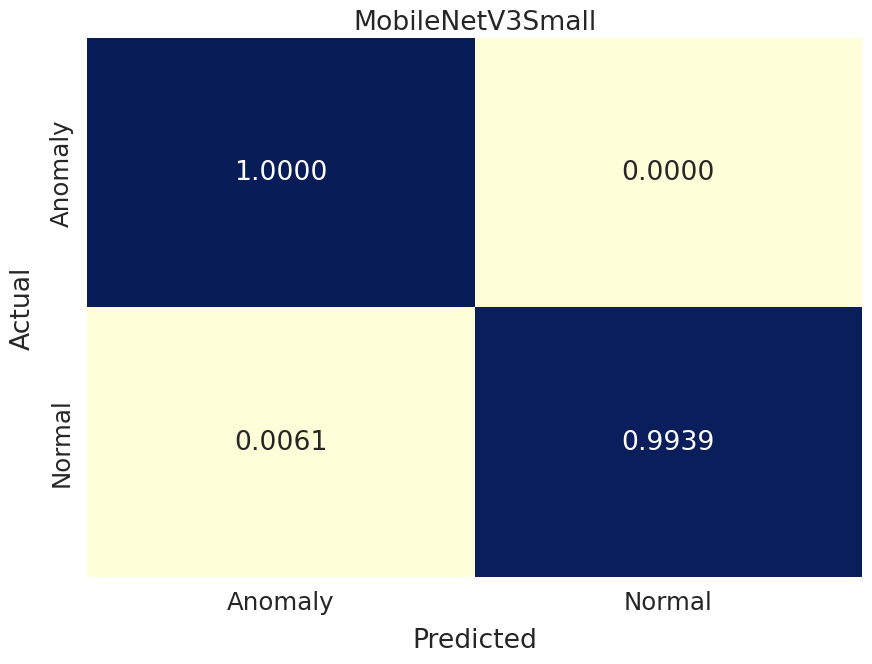

              precision    recall  f1-score   support

     Anomaly       0.98      1.00      0.99       145
      Normal       1.00      0.99      1.00       493

    accuracy                           1.00       638
   macro avg       0.99      1.00      0.99       638
weighted avg       1.00      1.00      1.00       638

AUC = 0.9970


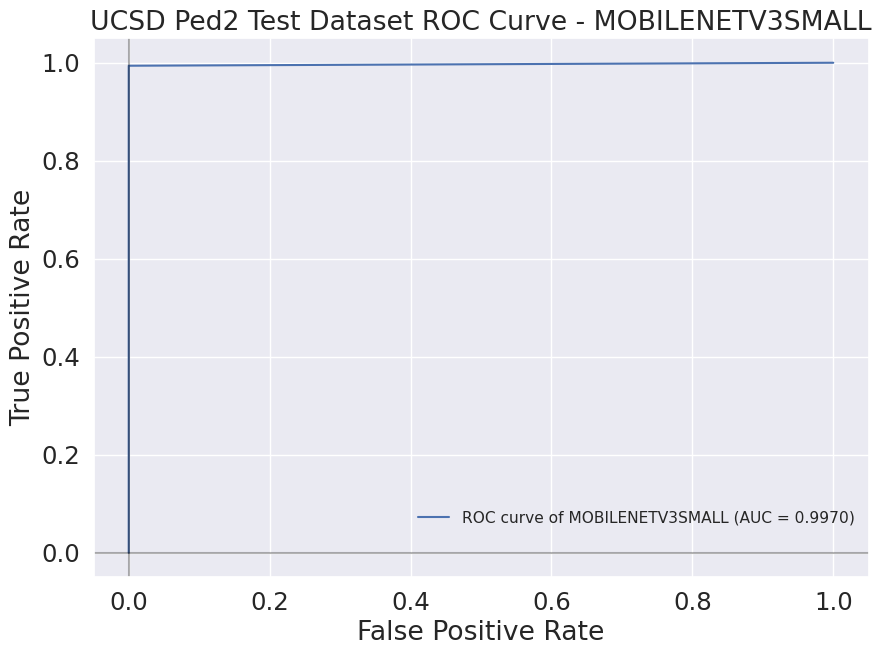

In [30]:
tf.keras.backend.clear_session()
gc.collect()

History_MobileNetV3Small = model_build_train(MobileNetV3Small,'MobileNetV3Small')

In [34]:
#@title Visualization of Results

def saveModelPlot(model_name):
  init_history_path = "/truba_scratch/tbag151/VAD_Output/Models/"+ choice + "/" + model_name+'/History/initial_history.npy'
  ft_history_path = "/truba_scratch/tbag151/VAD_Output/Models/"+ choice + "/" + model_name+'/History/ft_history.npy'

  history= np.load(init_history_path,allow_pickle=True).item()
  ft= np.load(ft_history_path,allow_pickle=True).item()
  initial_epochs= len(history['accuracy'])

  #############################################################################
  # Accuracy - epoch Graph
  acc = history['accuracy']
  val_acc = history['val_accuracy']
 
  acc += ft['accuracy']
  val_acc += ft['val_accuracy']

  #print(plt.style.available)
  plt.style.use('seaborn-v0_8-whitegrid') #seaborn-whitegrid 
  plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.plot([initial_epochs,initial_epochs],
  plt.ylim(), label='Start of Fine Tuning')
  plt.xlabel('epoch')
  plt.legend(loc='lower left')
  plt.title(model_name)
  plt.savefig(("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/Accuracy/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
  #############################################################################

  # Loss - epoch Graph
  loss = history['loss']
  val_loss = history['val_loss']

  loss += ft['loss']
  val_loss += ft['val_loss']

  plt.style.use('seaborn-v0_8-whitegrid') #seaborn-whitegrid 
  plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylabel('Loss')
  plt.ylim([min(plt.ylim()),1])
  plt.plot([initial_epochs,initial_epochs],
  plt.ylim(), label='Start of Fine Tuning')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.title(model_name)
  plt.savefig(("/truba_scratch/tbag151/VAD_Output/Images/" + choice + "/Loss/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)

In [35]:
#@title MobileNetV3Small Base Model
modelNameList=['MobileNetV3Small']

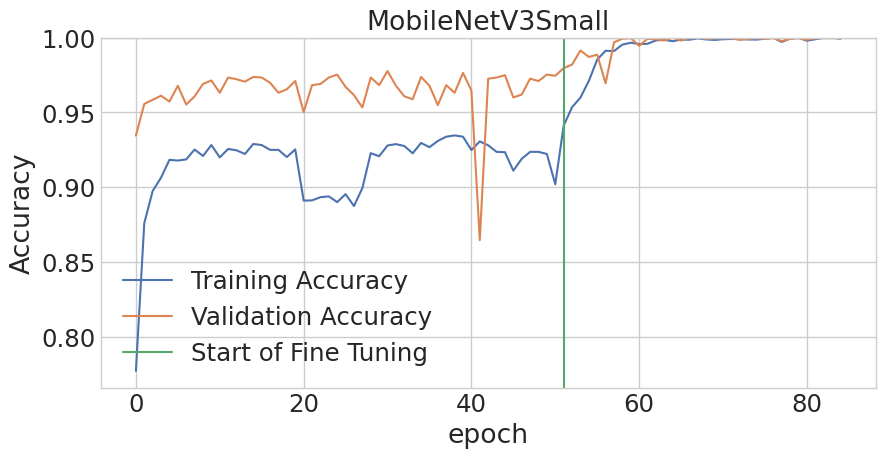

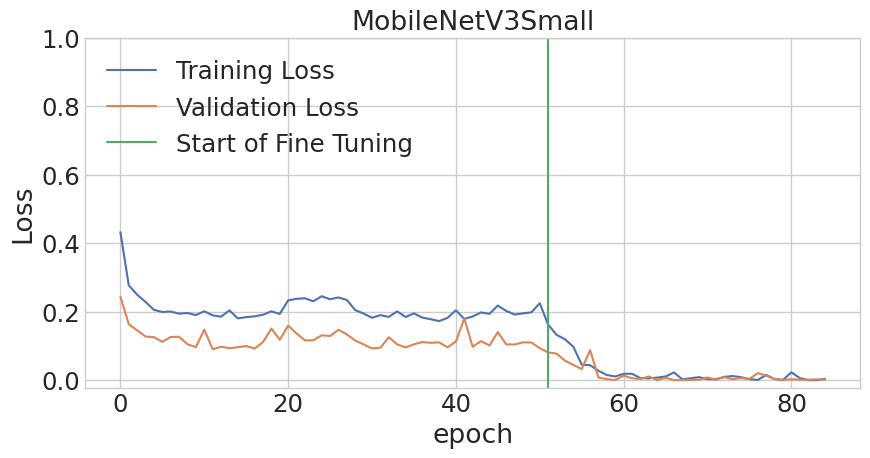

In [36]:
#@title Save Model Graphics to Disk
for model in modelNameList:
  saveModelPlot(model)